## Recommender system using matrix factorization techniques

In this project recommendation systems using matrix factorization techniques are analyzed. An item based collaborative filtering model is also built in order to compare the performance of the systems. 

Following matrix factorization techniques are explored in this project
- Singular Value Decomposition
- Alternating Least Square (ALS) 
     - ALS using package nifma
     - ALS using a coded function 
- Matrix Factorization using Gradient Descent(GD) (using tensorflow for GD)
     - Matrix factors using GD
     - Matrix factors using GD with weighted Errors


In [1]:
%%capture
import logging
logging.getLogger().setLevel(logging.ERROR)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphlab as gl
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14,10)

### Data Set
The movie lense (100k) dataset is used for this project. The data set contains 100k rating for 1682 movies from 943 users. 

Citation for Data Set  
F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets:
History and Context. ACM Transactions on Interactive Intelligent
Systems (TiiS) 5, 4, Article 19 (December 2015), 19 pages.
DOI=http://dx.doi.org/10.1145/2827872

In [2]:
#Read dataset using panda
rating = pd.read_csv("../data/u.data",sep="\t",usecols=[0,1,2],names=["uid","movie_id","rating"])

In [3]:
rating.head()

,uid,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
rating.shape

(100000, 3)

### Data Transformation

The movie rating is provided in long format. Let's convert it to wide format in order to perform dimension reduction.


In [5]:
#Long to wide
ratingw=rating.pivot_table(index="uid",columns="movie_id",values="rating")
ratingw.shape

(943, 1682)

### Dimension Reduction
The dataset provided is large and sparse. In order to build the recommendation engine without incurring too much of computing cost the data dimension needs to be reduced. For this project top 1000 movies (in terms of number of ratings, not by scale of rating) are considered. 
In order to remove user bias, the rating provided by a user is divided by mean user rating. The nifma package requires a non negative matrix to compute ALS. Hence the data is centered around 1 instead of 0. This method results in non uniform scale between above mean and below mean item. That is the different between a mean rating and a rating that is half of mean is 0.5 but difference between mean rating and twice mean rating is 1. But, this didn't affect the performance of the matrix based factorization methods. But, I tried this technique on the music data set (not detailed on this notebook) and it seemed to improve the performance (almost resulted in double precision). 


In [6]:
top_rat=ratingw.iloc[:,np.argsort(-ratingw.sum(axis=0))].iloc[:,0:1000]
top_rat=top_rat.div(top_rat.mean(axis=1),axis=0) #.div(top_rat.std(axis=1),axis=0)
top_rat.iloc[0:3,0:5]

movie_id,50,100,181,258,174
uid,,,,,
1,1.361229,1.361229,1.361229,1.361229,1.361229
2,1.327434,1.327434,NaN,0.796460,NaN
3,NaN,NaN,1.395973,0.697987,NaN


In [7]:
#Pick users who have listened to at least 15 movies
top_rat=top_rat[top_rat.count(axis=1)>15]
top_rat.shape

(943, 1000)

In [8]:
#Convert back to long format
top_ratl=top_rat.stack().reset_index()
top_ratl.columns=["uid","movie_id","rating"]

### Prepare test and train data
Used graplab package to split data for item based collaborative filtering. For matrix factorization technique 20% of the ratings are randomly selected and removed from training data. 

In [9]:
%%capture
rating_sf=gl.SFrame(top_ratl)
train_sf, test_sf = gl.recommender.util.random_split_by_user(rating_sf,user_id='uid', item_id='movie_id',
                            item_test_proportion=0.4, random_seed=0)


In [10]:
#Create a training dataset by removing 20% of available rating
ratings_partial= top_rat.applymap(lambda x: x if np.random.random(1)<= .6 else None)
print "Available Rating",np.sum(~np.isnan(top_rat.as_matrix()))
print "Rating to be used for matrix factorization",np.sum(~np.isnan(ratings_partial.as_matrix()))

Available Rating 95978
Rating to be used for matrix factorization 57449


### Item based collaborative filtering as benchmark
In order to get idea about performance of the matrix factorization methods, a item based collaborative model is built. The performance of the item based collaboration model is used as benchmark to evaluate matrix factorization techniques. 

In [11]:
%%capture
#Build IBCF model using graphlab - using cosine similarity
ibcm=gl.item_similarity_recommender.create(train_sf, user_id="uid",
                                           item_id="movie_id",target="rating",
                                           similarity_type='cosine',only_top_k=15)
#Make prediction
ibcm.predict(test_sf)
ibcm_reco=ibcm.recommend()

In [12]:
ib_pr_rec=gl.recommender.util.precision_recall_by_user(test_sf,ibcm_reco)
ib_pr_rec_df=ib_pr_rec.to_dataframe()
print "IBCF - Prediction RMSE", ibcm.evaluate_rmse(test_sf,target='rating')['rmse_overall']
print "IBCF - Precision:",ib_pr_rec_df.precision.mean()

IBCF - Prediction RMSE 1.02671782222
IBCF - Precision: 0.438918345705


### Utility function for recommender using Matrix Factorization  

Function to get top n rating from the completed matrix

In [13]:
def get_topn(rating,n=10):
    top_nrat=np.apply_along_axis(lambda row:np.argsort(-row)[:n],axis=1,arr=rating)
    return top_nrat

Compute RMSE and Precision when actual, training (i.e partial ratings) and filled matrices are provided

In [14]:
def eval_matrix_fill(actual,partial,filled,nreco=10):
    
    #Keep only new rating (that is remove rating present in training)
    test=np.isnan(partial) & ~np.isnan(actual)
    filled_new=np.copy(filled)
    filled_new[~np.isnan(partial)]=None

    rmse = np.sqrt(np.nanmean(np.square(filled[test] - actual[test])))
    topn=get_topn(filled_new,nreco)
    nuser,nrat=topn.shape
    pos_rat=0.0
    for i in range(nuser):
        pos_rat += np.nansum(actual[i,topn[i,]]>0)
    #print pos_rat
    precision = pos_rat/topn.size
    return((rmse,precision))

### ALS using nimfa package

In [15]:
import nimfa

In [16]:
lsnmf = nimfa.Lsnmf(ratings_partial.fillna(0).as_matrix(), max_iter=100, rank=10)
lsnmf_fit = lsnmf()

u_nifma = lsnmf_fit.basis()
v_nifma = lsnmf_fit.coef()
print "U Matrix Shape",u_nifma.shape
print "V Matrix Shape",v_nifma.shape

U Matrix Shape (943, 10)
V Matrix Shape (10, 1000)


In [17]:
filled_nifma= np.dot(u_nifma,v_nifma)
print "ALS-nifma Overall RMSE",np.sqrt(np.nanmean(np.square(filled_nifma-ratings_partial)))
rmse,precision = eval_matrix_fill(top_rat.as_matrix(),ratings_partial.as_matrix(),filled_nifma)
print "ALS-nifma RMSE for predicted values:",rmse
print "ALS-nifma Precision  for predicted values:",precision

ALS-nifma Overall RMSE 0.770356233077
ALS-nifma RMSE for predicted values: 0.808311621191
ALS-nifma Precision  for predicted values: 0.469141039236


### Singular Value Decomposition

In [18]:
import scipy.linalg as linalg

In [19]:
u_svd,s_svd,v_svd=linalg.svd(ratings_partial.fillna(0),full_matrices=False)

In order to approximate the matrix the top 10 singular values are considered. Then the rating matrix is reconstructed using the 10 singular values, that is only considering most informative factors.

In [20]:
s_select=s_svd.copy()
s_select[10:]=0
filled_svd= np.dot(np.dot(u_svd,np.diag(s_select)),v_svd)
print "SVD Overall RMSE",np.sqrt(np.nanmean(np.square(filled_svd-ratings_partial)))
rmse,precision = eval_matrix_fill(top_rat.as_matrix(),ratings_partial.as_matrix(),filled_svd)
print "SVD RMSE for predicted values:",rmse
print "SVD Precision  for predicted values:",precision

SVD Overall RMSE 0.754590094887
SVD RMSE for predicted values: 0.805397310962
SVD Precision  for predicted values: 0.490774125133


The SVD based method performed slightly better than ALS(from nifma package). Let's try ALS factorization with some regularization. 

### ALS - Function

The below function is based on the function provided in https://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/

In [21]:
def als(ratings,reg=0.1,ncols=10,iterations=100):
    errors=pd.Series(np.zeros(100))
    m,n = ratings.shape
    u = 5 * np.random.rand(m,ncols)  
    v = 5 * np.random.rand(ncols, n) 
    for i in range(iterations):
        u = np.linalg.solve(np.dot(v, v.T) + reg * np.diag([1]*ncols), 
                            np.dot(v, ratings.T)).T
        v = np.linalg.solve(np.dot(u.T, u) + reg * np.diag([1]*ncols),
                            np.dot(u.T, ratings))
        ratings_approx = np.dot(u, v)
        errors.set_value(i,np.sqrt(np.nanmean(np.square(ratings-ratings_approx))))
    return((u,v,errors))


Compute matrix factor using alternating least squares

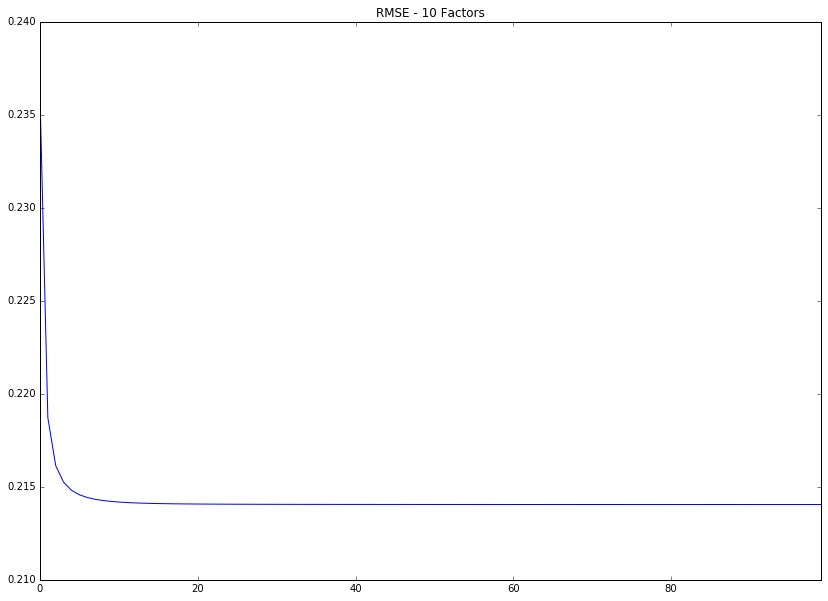

In [22]:
als_u,als_v,errors=als(ratings_partial.fillna(0).as_matrix(),ncols=10,iterations=100) 
errors.plot(title="RMSE - 10 Factors")

In [23]:
filled_als = np.dot(als_u,als_v)
print "ALS Overall RMSE",np.sqrt(np.nanmean(np.square(filled_als-ratings_partial)))
rmse,precision = eval_matrix_fill(top_rat.as_matrix(),ratings_partial.as_matrix(),filled_als)
print "ALS RMSE for predicted values:",rmse
print "ALS Precision for predicted values:",precision

ALS Overall RMSE 0.755844660453
ALS RMSE for predicted values: 0.80644976386
ALS Precision for predicted values: 0.490243902439


Matrix decomposition using ALS regularized provides precision rate and RMSE comparable to SVD. Let's increase the factor from 10 to 15 and check how it changes the performance.

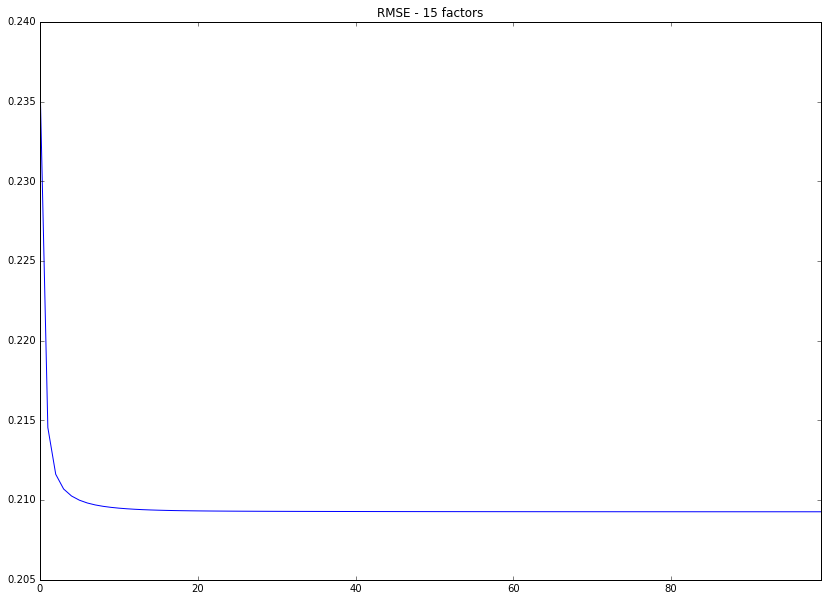

In [24]:
als_u,als_v,errors=als(ratings_partial.fillna(0).as_matrix(),ncols=15,iterations=100) 
errors.plot(title="RMSE - 15 factors")

In [25]:
filled_als = np.dot(als_u,als_v)
print "ALS Overall RMSE",np.sqrt(np.nanmean(np.square(filled_als-ratings_partial)))
rmse,precision = eval_matrix_fill(top_rat.as_matrix(),ratings_partial.as_matrix(),filled_als)
print "ALS RMSE for predicted values:",rmse
print "ALS Precision  for predicted values:",precision

ALS Overall RMSE 0.732361232859
ALS RMSE for predicted values: 0.814608485878
ALS Precision  for predicted values: 0.481548250265


While the overall RMSE reduced for 15 factors compared to 10 factors, the prediction RMSE and prediction precision slightly dropped which indicates overfitting.

### Matrix factorization using Gradient Descent  
Gradient Descent could be used to iteratively approximate the rating matrix as a product of two smaller matrices. By constructing the matrix factorization as optimization problem (i.e reducing error between original matrix and the product of factors). I used tensorflow to solve the optimization and come up with matrix factors. I tried two methods
- Reduce total squared error between Original matrix and Product of factors (Errors are not Weighted)
- Reduce total squared error between Original matrix and Product of factors where the errors are weighted based on wheather rating is available or not

#### Non weighted Errors

In [26]:
import tensorflow as tf
#Rating Matrix
r = tf.placeholder(tf.float32,[943,1000])
#U matrix
u_grad = tf.Variable(tf.random_normal([943,10],stddev=1))
#V matrix
v_grad = tf.Variable(tf.random_normal([10,1000],stddev=1))
# UV
y = tf.matmul(u_grad, v_grad)
#Total Error
loss = tf.reduce_sum(tf.square(r - y))
optimizer = tf.train.GradientDescentOptimizer(0.0001)

In [27]:
#Minimize total error
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
curr_u, curr_v, curr_loss = sess.run([u_grad, v_grad, loss], {r: ratings_partial.fillna(0)})
for i in range(1000):
    sess.run(train,{r:ratings_partial.fillna(0)})
    curr_u, curr_v, curr_loss = sess.run([u_grad, v_grad, loss], {r: ratings_partial.fillna(0)})
    if i % 100 == 0: print("loss: %s" % (curr_loss))

loss: 4.00965e+06
loss: 62203.7
loss: 52872.5
loss: 50273.2
loss: 49937.6
loss: 49646.7
loss: 49246.4
loss: 48737.6
loss: 48192.1
loss: 47703.4


In [28]:
filled_grad = np.dot(curr_u,curr_v)
print "Matrix factors using GD - Overall RMSE",np.sqrt(np.nanmean(np.square(filled_grad-ratings_partial)))

Matrix factors using GD - Overall RMSE 0.814093726878


In [29]:
rmse,precision = eval_matrix_fill(top_rat.as_matrix(),ratings_partial.as_matrix(),filled_grad)
print "Matrix factors using GD - MSE for predicted values:",rmse
print "Matrix factors using GD - Precision  for predicted values:",precision

Matrix factors using GD - MSE for predicted values: 0.840040411033
Matrix factors using GD - Precision  for predicted values: 0.397985153765


The performance of the Gradient descent is lower than ALS or SVD based matrix factorization methods.

#### Weighted Errors
I tried to reduce error between the matrices considering entries where rating is present. That gave smallest RMSE for training (less than 0.3 ), but the precision for prediction was bad (predicted precision was less than 10% and prediction RMSE was about 0.53).  

Below weight provided optimal solution
- Entries where rating is available - Weight of 6.5
- Entries where rating is not available - Weight of 1

In [30]:
#Set Error weights
error_weights=ratings_partial.copy()
error_weights[~np.isnan(ratings_partial)]=6.5
error_weights=error_weights.fillna(1)

In [31]:
#Error weight
err_w = tf.placeholder(tf.float32,[943,1000])
#Loss with weighted error
loss = tf.reduce_sum(tf.multiply(tf.square(r - y),err_w))
optimizer = tf.train.GradientDescentOptimizer(0.0001)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
curr_u, curr_v, curr_loss = sess.run([u_grad, v_grad, loss], {r: ratings_partial.fillna(0),
                                                              err_w:error_weights})
#print("u: %s v: %s loss: %s" % (curr_u, curr_v, curr_loss))
for i in range(1000):
    sess.run(train,{r:ratings_partial.fillna(0),err_w:error_weights})
    curr_u, curr_v, curr_loss = sess.run([u_grad, v_grad, loss], {r: ratings_partial.fillna(0),
                                                                 err_w:error_weights})
    if i % 100 == 0: print("loss: %s" % (curr_loss))

loss: 3.90828e+06
loss: 193404.0
loss: 171810.0
loss: 159038.0
loss: 153144.0
loss: 150107.0
loss: 148245.0
loss: 147005.0
loss: 146156.0
loss: 145567.0


In [32]:
filled_gradw = np.dot(curr_u,curr_v)
print "Matrix factors using GD (Weighted Errors) - Overall RMSE",\
           np.sqrt(np.nanmean(np.square(filled_gradw-ratings_partial)))

Matrix factors using GD (Weighted Errors) - Overall RMSE 0.45799591781


In [33]:
rmse,precision = eval_matrix_fill(top_rat.as_matrix(),ratings_partial.as_matrix(),filled_gradw)
print "Matrix factors using GD (Weighted Errors) - RMSE for predicted values:",rmse
print "Matrix factors using GD (Weighted Errors) - Precision  for predicted values:",precision

Matrix factors using GD (Weighted Errors) - RMSE for predicted values: 0.528243477263
Matrix factors using GD (Weighted Errors) - Precision  for predicted values: 0.478154825027


### Summary

For the movielens dataset recommendation system based on matrix factorization technique provided better precision rate compared to item based collaborative filtering. The performance of Singular Value Decomposition and Alternate Least Squares methods are performed pretty much similar. The gradient descent model's performance while no weights for errors were used was lower than ALS/SVD methods.But, I was able to improve the performance of the gradient descent based factorization model by using weighted error (with higher weight for available ratings). The matrix factorization using gradient descent with weighted error provided best RMSE (about 0.52 for predicted values) and comparable prediction precision (about 47%), but the gradient descent model was expensive in terms of computation. 